[ ] Fix the latent variance calculations. (I think it's just taking total variance instead of the 2 norm of z vectors.)

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

In [ ]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts.head()

In [ ]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(100)
clustering.create_spot_data(third_dim=False, save_data=True)

In [ ]:
HIGHLY_VARIABLE = False
clustering.normalize_counts(clustering.xenium_spot_data)

In [ ]:
HIGHLY_VARIABLE = True
clustering.filter_only_high_variable_genes(clustering.xenium_spot_data)
# generate the neigborhood graph based on pca
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack')
sc.pl.pca_variance_ratio(clustering.xenium_spot_data)
clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]

In [ ]:
clustering.xenium_spot_data.var, clustering.xenium_spot_data.var.shape

In [ ]:
clustering.xenium_spot_data.obs, clustering.xenium_spot_data.obs.shape

In [ ]:
expression_data = pd.DataFrame(clustering.xenium_spot_data.X, columns=clustering.xenium_spot_data.var.index)
clustering.xenium_spot_data.obs.index = clustering.xenium_spot_data.obs.index.astype(int)
input_data = clustering.xenium_spot_data.obs.join(expression_data)
input_data.head()

### Reconstruction Loss

Input: $X$

Reconstruction: $X^{'}$

$$(X - X^{'})^2$$

### Spatial Loss

Left Boundary $(l)$: $\max(0, j - n)$

Right Boundary $(r)$: $\min(0, j + n)$

Top Boundary $(t)$: $\max(0, i - n)$

Bottom Boundary $(b)$: $\min(0, i + n)$

$$\frac{1}{IJ} \sum_{i=1}^I \sum_{j=1}^{J} \frac{1}{(r-l+1)(b-t+1)}\sum_{i^{'} = b}^{t} \sum_{j^{'}=l}^{r} D_{KL}(C[i^{'}, j^{'}], C[i, j]) $$

### Entropy Regularization

$$- \frac{1}{IJK} \sum_{i=1}^{I}\sum_{j=1}^{J}\sum_{k=1}^{K} p_{i,j}(k) \log(p_{i,j}(k)) $$

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "[1]"


In [288]:
class ClassifierAutoEncoder(L.LightningModule):

    def __init__(
            self,
            spot_height,
            spot_width,
            spot_depth = None,
            within_cluster_distance_hyperparam = 1,
            within_cluster_penalty_hyperparam = 1, 
            spatial_penalty_hyperparam = 1,
            entropy_penalty_hyperparam = 1,
            cluster_util_penalty_hyperparam = 1,
            neighborhood_size = 5,
            num_clusters = 10
        ):

        self.within_cluster_distance_hyperparam = within_cluster_distance_hyperparam
        self.within_cluster_penalty_hyperparam = within_cluster_penalty_hyperparam
        self.spatial_penalty_hyperparam = spatial_penalty_hyperparam
        self.entropy_penalty_hyperparam = entropy_penalty_hyperparam
        self.cluster_util_penalty_hyperparam = cluster_util_penalty_hyperparam
        self.neighborhood_size = neighborhood_size
        self.num_clusters = num_clusters
        self.input_size = 180 if HIGHLY_VARIABLE else 541
        self.kernel_size = 5
        self.stride = 2
        self.padding = 0
        self.spot_height = spot_height
        self.spot_width = spot_width
        self.spot_depth = spot_depth

        self.loss_array = []

        super(ClassifierAutoEncoder, self).__init__()

        # Encoder Layers
        in_channels = self.input_size
        # out channels needs to be multiplied by the same quantity the number of spots is reduced by
        out_channels = self.calculate_out_channels(in_channels, self.kernel_size, self.stride, self.padding)
        in_size_enc1 = torch.tensor([self.spot_height, self.spot_width], dtype=int)
        out_size_enc1 = self.calculate_output_size(in_size_enc1, self.kernel_size, self.stride, self.padding)
        print(in_size_enc1, out_size_enc1)
        self.enc_conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.enc_batchnorm1 = torch.nn.BatchNorm2d(out_channels)

        in_channels = out_channels
        out_channels = self.calculate_out_channels(in_channels, self.kernel_size, self.stride, self.padding)
        in_size_enc2 = out_size_enc1
        out_size_enc2 = self.calculate_output_size(in_size_enc2, self.kernel_size, self.stride, self.padding)
        print(in_size_enc2, out_size_enc2)
        self.enc_conv2 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.enc_batchnorm2 = torch.nn.BatchNorm2d(out_channels)

        in_channels = out_channels
        out_channels = self.adjust_out_channels(self.calculate_out_channels(in_channels, self.kernel_size, self.stride, self.padding), self.spot_height, self.spot_width)
        in_size_enc3 = out_size_enc2
        out_size_enc3 = self.calculate_output_size(in_size_enc3, self.kernel_size, self.stride, self.padding)
        print(in_size_enc3, out_size_enc3)
        self.enc_conv3 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.enc_batchnorm3 = torch.nn.BatchNorm2d(out_channels)

        self.activation = torch.nn.LeakyReLU()

        # Decoder Layers
        in_channels = out_channels
        in_size_dec1 = out_size_enc3
        out_size_dec1 = self.calculate_output_size(in_size_dec1, self.kernel_size, self.stride, self.padding, transpose=True)
        output_padding1 = torch.max(torch.abs(out_size_dec1 - in_size_enc3)).item()
        if output_padding1:
            out_size_dec1 = self.calculate_output_size(in_size_dec1, self.kernel_size, self.stride, self.padding, output_padding=output_padding1, transpose=True)
        print(in_size_dec1, out_size_dec1)
        self.dec_conv1 = torch.nn.ConvTranspose2d(in_channels, 256, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, output_padding=output_padding1)
        self.dec_batchnorm1 = torch.nn.BatchNorm2d(256)

        in_size_dec2 = out_size_dec1
        out_size_dec2 = self.calculate_output_size(in_size_dec2, self.kernel_size, self.stride, self.padding, transpose=True)
        output_padding2 = torch.max(torch.abs(out_size_dec2 - in_size_enc2)).item()
        if output_padding2:
            out_size_dec2 = self.calculate_output_size(in_size_dec2, self.kernel_size, self.stride, self.padding, output_padding=output_padding2, transpose=True)
        print(in_size_dec2, out_size_dec2)
        self.dec_conv2 = torch.nn.ConvTranspose2d(256, 256, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, output_padding=output_padding2)
        self.dec_batchnorm2 = torch.nn.BatchNorm2d(256)

        in_size_dec3 = out_size_dec2
        out_size_dec3 = self.calculate_output_size(in_size_dec3, self.kernel_size, self.stride, self.padding, transpose=True)
        output_padding3 = torch.max(torch.abs(out_size_dec3 - in_size_enc1)).item()
        if output_padding3:
            out_size_dec3 = self.calculate_output_size(in_size_dec3, self.kernel_size, self.stride, self.padding, output_padding=output_padding3, transpose=True) 
        print(in_size_dec3, out_size_dec3)     
        self.dec_conv3 = torch.nn.ConvTranspose2d(256, self.input_size, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, output_padding=output_padding3)

        # cluster layers
        in_channels = torch.prod(out_size_enc3).item()
        self.clust_linear1 = torch.nn.Linear(in_channels, 256)
        self.clust_linear2 = torch.nn.Linear(256, 128)
        self.clust_linear3 = torch.nn.Linear(128, self.num_clusters)
        self.clust_softmax = torch.nn.Softmax(dim=1)

        self.encoder = torch.nn.Sequential(
            self.enc_conv1,
            self.enc_batchnorm1,
            self.activation,
            self.enc_conv2, 
            self.enc_batchnorm2,   
            self.activation,       
            self.enc_conv3,  
            self.enc_batchnorm3    
        )

        self.decoder = torch.nn.Sequential(
            self.dec_conv1,
            self.dec_batchnorm1,
            self.activation,
            self.dec_conv2, 
            self.dec_batchnorm2,
            self.activation,          
            self.dec_conv3, 
        )

        self.cluster_assignment = torch.nn.Sequential(
            self.clust_linear1,
            self.activation,
            self.clust_linear2,
            self.activation,
            self.clust_linear3,
            self.clust_softmax 
        )

    @staticmethod
    def calculate_output_size(input_size, kernel_size, stride, padding, dilation=1, output_padding=0, transpose=False):
        if transpose:
            output_size = (input_size - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1
        else:
            output_size = (input_size + (2 * padding) - kernel_size) // stride + 1
        return output_size

    @staticmethod
    def calculate_out_channels(in_channels, kernel_size, stride, padding):
        output_size = (in_channels - 1) * stride + kernel_size - (2 * padding)
        return output_size

    @staticmethod
    def adjust_out_channels(out_channels, height, width):
        total_pixels = height * width
        if out_channels % total_pixels == 0:
            return out_channels 
        else:
            return ((out_channels // total_pixels) + 1) * total_pixels
        
    def training_step(self, batch, batch_idx):

        x, x_hat, z, cluster = self(batch)

        try:
            zeros = self.training_mask(x).unsqueeze(0).unsqueeze(0)

            # Apply mask to input and reconstruction
            x_masked = x * zeros
            x_hat_masked = x_hat * zeros
            z_masked = z * torch.flatten(zeros).view(-1,1)
            cluster_masked = cluster * torch.flatten(zeros).view(-1,1)
        except:
            # Apply mask to input and reconstruction
            x_masked = x
            x_hat_masked = x_hat
            z_masked = z
            cluster_masked = cluster
            print("The masking procedure did not work.")

        loss = self.spatial_loss_function(x_masked, x_hat_masked, z_masked, cluster_masked)

        formatted_loss = round(loss.item(), 4)
        print(formatted_loss)
        self.loss_array.append(formatted_loss)
        print(f"# of Clusters: {cluster_masked.argmax(dim=1).unique().numel()}")

        return loss

    def validation_step(self, batch, batch_idx):
        x, x_hat, z, cluster = self(batch)
        try:
            zeros = self.training_mask(x).unsqueeze(0).unsqueeze(0)

            # Apply mask to input and reconstruction
            x_masked = x * zeros
            x_hat_masked = x_hat * zeros
            z_masked = z * torch.flatten(zeros).view(-1,1)
            cluster_masked = cluster * torch.flatten(zeros).view(-1,1)
        except:
            # Apply mask to input and reconstruction
            x_masked = x
            x_hat_masked = x_hat
            z_masked = z
            cluster_masked = cluster
            print("The masking procedure did not work.")

        loss = self.spatial_loss_function(x_masked, x_hat_masked, z_masked, cluster_masked)

        return loss

    def test_step(self, batch, batch_idx):
        x, x_hat, z, cluster = self(batch)
        try:
            zeros = self.training_mask(x).unsqueeze(0).unsqueeze(0)

            # Apply mask to input and reconstruction
            x_masked = x * zeros
            x_hat_masked = x_hat * zeros
            z_masked = z * torch.flatten(zeros).view(-1,1)
            cluster_masked = cluster * torch.flatten(zeros).view(-1,1)
        except:
            # Apply mask to input and reconstruction
            x_masked = x
            x_hat_masked = x_hat
            z_masked = z
            cluster_masked = cluster
            print("The masking procedure did not work.")

        loss = self.spatial_loss_function(x_masked, x_hat_masked, z_masked, cluster_masked)

        return loss

    def cluster_utilization_and_entropy_loss(self, cluster_probs, min_cluster_rate=0.1, beta=1.0):
        # Assuming cluster_probs is a Tensor of shape [N, num_clusters]
        # where N is the number of samples and num_clusters is the number of possible clusters.

        # Calculate the mean probability of each cluster being chosen across all samples
        mean_probs = torch.mean(cluster_probs, dim=0)
        
        # Calculate the shortfall for each cluster from the minimum rate
        shortfalls = min_cluster_rate - mean_probs
        
        # Apply ReLU to get positive shortfalls only (negative values become zero)
        positive_shortfalls = torch.nn.functional.relu(shortfalls)
        
        # Square the shortfalls to penalize larger deviations more severely
        squared_penalties = positive_shortfalls ** 2
        
        # Sum the squared penalties to get the total utilization loss
        utilization_loss = torch.sum(squared_penalties)
        
        # Calculate entropy of the mean probabilities to encourage confident predictions
        entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-10))  # Adding a small constant to prevent log(0)
        
        # Total loss combines utilization loss and entropy scaled by a factor beta
        total_loss = utilization_loss + beta * entropy
        
        return total_loss


    def spatial_loss_function(self, input, reconstruction, latents, cluster_assignments):
        reconstruction_loss = F.mse_loss(input, reconstruction)
        within_cluster_penalty = self.within_cluster_average_latent_dissimilarity(latents, cluster_assignments)
        spatial_cluster_penalty = self.neighboring_cluster_dissimilarity(cluster_assignments, input)
        within_cluster_distance = self.within_cluster_distance(cluster_assignments, input)
        entropy_penalty = self.entropy_regularization(cluster_assignments, input)
        diff_clusters = self.cluster_utilization_and_entropy_loss(cluster_assignments)
        print(f"""LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Within Distance, Spatial, Cluster Different) 
              ({reconstruction_loss}, {self.within_cluster_penalty_hyperparam * within_cluster_penalty}, {self.within_cluster_distance_hyperparam * within_cluster_distance}, {self.spatial_penalty_hyperparam * spatial_cluster_penalty}, {self.cluster_util_penalty_hyperparam * diff_clusters})
              """)
        return reconstruction_loss + self.within_cluster_distance_hyperparam * within_cluster_distance + self.within_cluster_distance_hyperparam * within_cluster_distance

    def within_cluster_average_latent_dissimilarity(self, z, cluster, margin=5.0, samples_per_cluster=25):
        cluster_assignments = cluster.argmax(dim=1)
        # Initialize triplet loss function
        triplet_loss = torch.nn.TripletMarginLoss(margin=margin)

        # Find unique clusters
        unique_clusters = cluster_assignments.unique()

        # Preparing lists to hold anchor, positive, and negative examples
        anchor_list = []
        positive_list = []
        negative_list = []

        # Loop through each cluster to select anchor and positive, and find negative from other clusters
        for cluster in unique_clusters:
            # Indices for current cluster and other clusters
            current_cluster_indices = (cluster_assignments == cluster).nonzero().squeeze()
            other_clusters_indices = (cluster_assignments != cluster).nonzero().squeeze()

            # Check if there are enough samples
            for _ in range(samples_per_cluster):
                if current_cluster_indices.numel() > 1 and other_clusters_indices.numel() > 1:
                    # Randomly choose one sample to be the anchor and another to be the positive sample
                    anchor_pos_indices = torch.randperm(len(current_cluster_indices))[:2]
                    anchor_index = current_cluster_indices[anchor_pos_indices[0]]
                    positive_index = current_cluster_indices[anchor_pos_indices[1]]

                    # Randomly choose one sample from another cluster to be the negative sample
                    negative_index = other_clusters_indices[torch.randperm(len(other_clusters_indices))[0]]

                    # Add to lists
                    anchor_list.append(z[anchor_index])
                    positive_list.append(z[positive_index])
                    negative_list.append(z[negative_index])

        # Stack lists to create tensors for the triplet loss calculation
        if anchor_list:
            anchor_tensor = torch.stack(anchor_list)
            positive_tensor = torch.stack(positive_list)
            negative_tensor = torch.stack(negative_list)

            # Calculate the triplet loss
            loss = triplet_loss(anchor_tensor, positive_tensor, negative_tensor) 
            return loss

        # Compute a penalty based on the norm of embeddings when no triplets are available
        penalty = torch.norm(1000. * z, p=2)  # You can adjust the norm type and scaling factor as needed
        return penalty
    

    def within_cluster_distance(self, cluster_probabilities, x):
        device = cluster_probabilities.device  # Get the device of the probabilities (presumably GPU)
        batch, channels, height, width = x.shape
        num_clusters = cluster_probabilities.size(1)
        
        # Reshape cluster probabilities and coordinates for pairwise distance computation
        cluster_probabilities = cluster_probabilities.view(height * width, num_clusters)
        coordinates = torch.stack(torch.meshgrid(torch.arange(height, device=device), torch.arange(width, device=device)), dim=-1)
        coordinates = coordinates.view(-1, 2).float()  # Flatten and convert to float
        coordinates /= max(height, width)  # Normalize coordinates

        # Calculate the pairwise probability that points belong to the same cluster
        same_cluster_probs = torch.matmul(cluster_probabilities, cluster_probabilities.t())

        # Compute pairwise distances for all points
        pairwise_distances = torch.cdist(coordinates, coordinates, p=2)

        # Weight distances by the pairwise cluster probabilities
        within_cluster_distances = same_cluster_probs * pairwise_distances

        # Since we've computed all pairs twice, we halve the result (and ignore the diagonal)
        mask = torch.ones(within_cluster_distances.size(), device=device).fill_diagonal_(0)
        within_cluster_distances *= mask

        # Sum over upper triangle matrix to avoid double-counting pairs
        total_within_cluster_distance = within_cluster_distances.triu(diagonal=1).sum()

        return total_within_cluster_distance

    
    def neighboring_cluster_dissimilarity(self, cluster, x, zero_correction = 1e-9):
        batch, channels, height, width = x.shape
        spots, num_clusters = cluster.shape
        spatial_cluster = cluster.view(height, width, num_clusters)
        dissimilarity_values = []
        for i in range(height):
            for j in range(width):

                left_boundary = max(0, j - self.neighborhood_size)
                right_boundary = min(width, j + self.neighborhood_size + 1)
                top_boundary = max(0, i - self.neighborhood_size)
                bottom_boundary = min(height, i + self.neighborhood_size + 1)
                neighborhood = spatial_cluster[top_boundary:bottom_boundary, left_boundary:right_boundary]

                central_pixel_distr = spatial_cluster[i, j, :].unsqueeze(0).unsqueeze(0)
                kl_divergences = F.kl_div((central_pixel_distr + zero_correction).log(), neighborhood + zero_correction, reduction='none', log_target=False)
                dissimilarity = kl_divergences.sum(dim=-1).mean(dim=(0, 1))

                dissimilarity_values.append(dissimilarity.unsqueeze(0))

        dissimilarities = torch.cat(dissimilarity_values).to(x.device)
        return torch.sum(dissimilarities)  
    
    def entropy_regularization(self, cluster_probs, x, zero_correction = 1e-9):
        batch, channels, height, width = x.shape
        spots, num_clusters = cluster_probs.shape
        spatial_cluster = cluster_probs.view(height, width, num_clusters)
        entropy = -torch.sum(spatial_cluster * torch.log(spatial_cluster + zero_correction), dim=2)
        entropy_loss = torch.mean(entropy)
        return entropy_loss

    def forward(self, x):

        batch, channels, height, width = x.shape

        # Encoding path
        x1 = self.enc_conv1(x)
        x1 = self.enc_batchnorm1(x1)
        x1 = self.activation(x1)
        
        x2 = self.enc_conv2(x1)
        x2 = self.enc_batchnorm2(x2)
        x2 = self.activation(x2)
        
        x3 = self.enc_conv3(x2)
        x3 = self.enc_batchnorm3(x3)
        z = self.activation(x3)
        z = z.view(1, -1, height, width)

        # Decoding path
        d1 = self.dec_conv1(x3)
        d1 = self.dec_batchnorm1(d1)
        d1 = self.activation(d1)
        # d1 += x2  # Residual connection from x3 to d1

        d2 = self.dec_conv2(d1)
        d2 = self.dec_batchnorm2(d2)
        d2 = self.activation(d2)
        # d2 += x1  # Residual connection from x2 to d2

        x_hat = self.dec_conv3(d2)

        # Flattening for clustering
        batch_size, channels, height, width = z.size()
        z = z.view(batch_size * height * width, channels)
        cluster = self.cluster_assignment(z)

        return x, x_hat, z, cluster

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

Epoch 0:   0%|          | 0/1 [04:20<?, ?it/s]


In [289]:
gene_data = []

for gene in clustering.xenium_spot_data.var.index:
    gene_channel = pd.pivot(input_data, index = 'row', columns = 'col', values = f"{gene}").fillna(0)
    gene_tensor = torch.tensor(gene_channel.to_numpy())
    gene_data.append(gene_tensor)

input_tensor = torch.stack(gene_data, dim=0)
input_tensor.shape

torch.Size([180, 88, 104])

In [290]:
channels, spot_height, spot_width = input_tensor.shape
input_tensor = input_tensor.float()
input_tensor.to(dtype=torch.float32)
print(input_tensor.shape)
dataset = [input_tensor]
dataloader = DataLoader(dataset, batch_size=1)

model = ClassifierAutoEncoder(spot_height, spot_width, within_cluster_distance_hyperparam = 1e-6, within_cluster_penalty_hyperparam = 0.5, spatial_penalty_hyperparam = 0.1, cluster_util_penalty_hyperparam = 1, neighborhood_size = 20, num_clusters=10)

torch.Size([180, 88, 104])
tensor([ 88, 104]) tensor([42, 50])
tensor([42, 50]) tensor([19, 23])
tensor([19, 23]) tensor([ 8, 10])
tensor([ 8, 10]) tensor([19, 23])
tensor([19, 23]) tensor([42, 50])
tensor([42, 50]) tensor([ 88, 104])


In [291]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(model=model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name               | Type            | Params
--------------------------------------------------------
0  | enc_conv1          | Conv2d          | 1.6 M 
1  | enc_batchnorm1     | BatchNorm2d     | 726   
2  | enc_conv2          | Conv2d          | 6.6 M 
3  | enc_batchnorm2     | BatchNorm2d     | 1.5 K 
4  | enc_conv3          | Conv2d          | 166 M 
5  | enc_batchnorm3     | BatchNorm2d     | 18.3 K
6  | activation         | LeakyReLU       | 0     
7  | dec_conv1          | ConvTranspose2d | 58.6 M
8  | dec_batchnorm1     | BatchNorm2d     | 512   
9  | dec_conv2          | ConvTranspose2d | 1.6 M 
10 | dec_batchnorm2     | BatchNorm2d     | 512   
11 | dec_conv3          | ConvTranspose2d | 1.2 M 
12 | clust_linear1      | Linear          | 20.7 K
13 | clust_linear2      | Linear          | 32.9 K
14 | clust_linear3      | Line

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] torch.Size([1, 363, 42, 50])
torch.Size([1, 729, 19, 23])
torch.Size([1, 9152, 8, 10])
torch.Size([1, 80, 88, 104])
torch.Size([1, 256, 19, 23])
torch.Size([1, 256, 42, 50])
torch.Size([1, 180, 88, 104])
The masking procedure did not work.
LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Within Distance, Spatial, Cluster Different) 
              (3.7445485591888428, 2.405184507369995, 2.0260918140411377, 1.565032958984375, 2.3010449409484863)
              
7.3357
# of Clusters: 9
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=345]        torch.Size([1, 363, 42, 50])
torch.Size([1, 729, 19, 23])
torch.Size([1, 9152, 8, 10])
torch.Size([1, 80, 88, 104])
torch.Size([1, 256, 19, 23])
torch.Size([1, 256, 42, 50])
torch.Size([1, 180, 88, 104])
The masking procedure did not work.
LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Within Distance, Spatial, Cluster Different) 
              (3.5574252605438232, 2.3027069568634

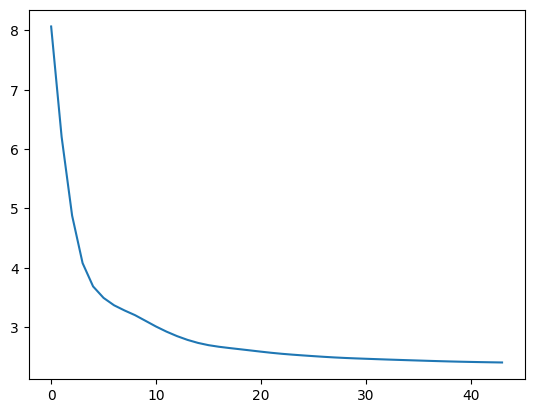

In [88]:
plt.plot(range(len(model.loss_array)), model.loss_array)

In [89]:
predictions = trainer.predict(model = model, dataloaders = dataloader)

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.36it/s]


In [90]:
# Plot the tensor
inputs, reconstruction, latents, clusters = predictions[0]
clusters

tensor([[0.1060, 0.1020, 0.0972,  ..., 0.1029, 0.0946, 0.0969],
        [0.1073, 0.1014, 0.0973,  ..., 0.1024, 0.0973, 0.0963],
        [0.1057, 0.1024, 0.0969,  ..., 0.1017, 0.0952, 0.0978],
        ...,
        [0.1059, 0.1016, 0.0975,  ..., 0.1022, 0.0956, 0.0969],
        [0.1047, 0.1023, 0.0967,  ..., 0.1027, 0.0954, 0.0979],
        [0.1067, 0.1015, 0.0979,  ..., 0.1031, 0.0958, 0.0968]])

(array([ 6.,  0.,  0.,  0.,  0., 53.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 19 artists>)

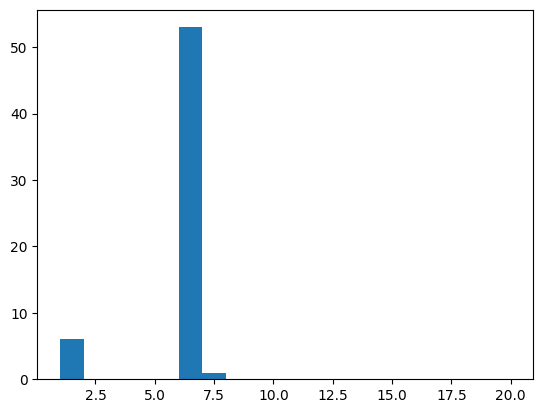

In [91]:
clusters.argmax(dim=1)
plt.hist(clusters.argmax(dim=1), bins=range(1, 21))

In [92]:
inputs.shape

torch.Size([1, 180, 88, 104])

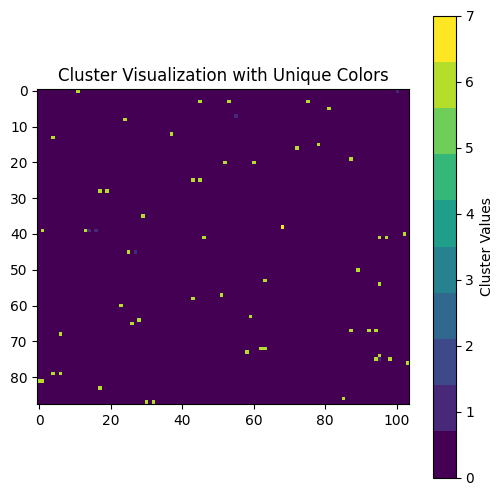

In [93]:
# Plot the tensor
inputs, reconstruction, latents, clusters = predictions[0]
num_possible_clusters = clusters.shape[1]

# Get unique values and create a colormap
batch, channels, height, width = inputs.shape
clusters = clusters.argmax(dim=1).view(height, width)
clusters_np = clusters.numpy()

colors = plt.cm.get_cmap('viridis', num_possible_clusters)
colormap = ListedColormap(colors(np.linspace(0, 1, num_possible_clusters)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(clusters_np, cmap=colormap, interpolation='nearest')
plt.colorbar(ticks=range(num_possible_clusters), label='Cluster Values')
plt.title('Cluster Visualization with Unique Colors')
plt.show()

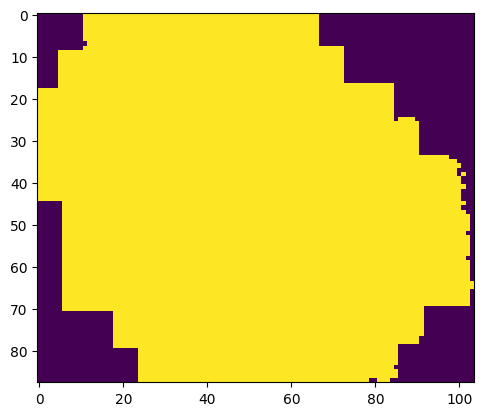

In [94]:
zeros = inputs.view(channels, height, width)
zeros = (zeros.sum(dim=0) != 0)
zeros = torch.tensor(zeros, dtype=int)

plt.imshow(zeros)

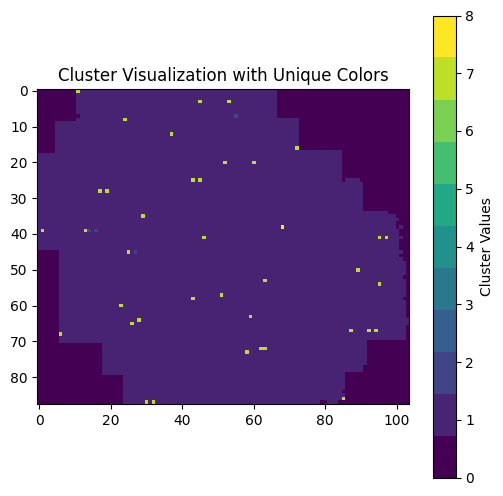

In [95]:
# Plot the tensor
inputs, reconstruction, latents, clusters = predictions[0]
num_possible_clusters = clusters.shape[1] + 1

# Get unique values and create a colormap
batch, channels, height, width = inputs.shape
zeros = inputs.view(channels, height, width)
zeros = (zeros.sum(dim=0) != 0)
zeros = torch.tensor(zeros, dtype=int)
clusters = clusters.argmax(dim=1).view(height, width)
clusters = (clusters + 1) * zeros
clusters_np = clusters.numpy()

colors = plt.cm.get_cmap('viridis', num_possible_clusters)
colormap = ListedColormap(colors(np.linspace(0, 1, num_possible_clusters)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(clusters_np, cmap=colormap, interpolation='nearest')
plt.colorbar(ticks=range(num_possible_clusters), label='Cluster Values')
plt.title('Cluster Visualization with Unique Colors')
plt.show()

In [ ]:
colormap

Try: Contrastive Loss

Include: Post-Processing Clean Up (like Graph Cut or Markov Random Fields)

1. Neighborhood Size and Spatial Penalty
     - Conditional Random Fields
2. Loss Function Weights

      - Hyperparameter Tuning: Review the weights (within_cluster_distance_hyperparam, within_cluster_penalty_hyperparam, spatial_penalty_hyperparam, entropy_penalty_hyperparam, cluster_util_penalty_hyperparam) assigned to each component of the loss function. Experiment with these to see if increasing the weight of the spatial penalty helps improve spatial coherence.

3. Clustering Mechanism and Output Layer
     - Increase the latent dimension (originally was 15).
4. Data Preprocessing and Batch Effects
Make sure that the input data is appropriately preprocessed and normalized. Variations in data scaling or the presence of outliers can adversely affect clustering performance.

Normalization and Standardization: Ensure that your data input to the model is well-preprocessed, including tasks like normalization or standardization, especially if dealing with image data.
Batch Effects: Sometimes, how data is batched during training can affect learning dynamics, especially in cases where spatial relationships are important. Make sure the batching process does not obscure spatial relationships.


1. Modifying Convolutional Kernel Size and Stride
     - Smaller kernels.
     - Larger strides.

2. Incorporating Dilated Convolutions
Dilated convolutions can help expand the receptive field without increasing the direct overlap of the convolution kernels. This approach allows the model to integrate spatial context from a broader area without necessarily forcing close-by pixels to share similar feature representations as strongly as standard convolutions do.

3. Advanced Architectural Changes
Incorporating elements that specifically address the preservation of spatial boundaries, such as CRFs (Conditional Random Fields) integrated within or after the deep learning model, can significantly enhance the ability to maintain clear and meaningful cluster boundaries. CRFs are particularly adept at modeling spatial relationships and can enforce cluster boundary consistency more effectively.

 Use Strided Convolutions for Downsampling
Instead of traditional pooling layers, you can use strided convolutions to reduce spatial dimensions. This method effectively reduces the height and width while increasing the depth (number of channels), which compensates for the reduced spatial resolution by capturing more detailed feature information in the channel dimension.

Upsampling in Decoder: In the decoder, you can use transposed convolutions (often called deconvolutions) with appropriate stride to upsample the spatial dimensions back to the original size.
2. Incorporate Dilated Convolutions
Dilated convolutions allow you to expand the receptive field without reducing the spatial dimension of the output. This technique can be particularly useful if you want to capture broader context without losing resolution.

3. Max-Pooling with Indices (Max-Unpooling)
A specific technique that can be helpful is max-pooling with indices, often used in segmentation tasks:

Max-Pooling with Indices: This type of pooling keeps track of the positions of the maxima within each pooling window. This information is then used during the upsampling phase to place the values back into their original locations, allowing for precise reconstruction.
Max-Unpooling: In the decoder, use the stored indices to perform max-unpooling, which restores the data to its original dimensions by placing the max values back into their recorded positions, while other values are typically set to zero.
4. PixelShuffle for Upsampling
The PixelShuffle operation is an efficient and simple way to increase the resolution of an image or feature map. It works by rearranging elements from a low-resolution input into a high-resolution output, by reshuffling the tensor dimensions:

Increase Channels Instead of Downsampling: Modify the encoder to increase the number of channels rather than reducing the spatial dimensions. Then, in the decoder, use PixelShuffle to reduce the channel depth while increasing the spatial dimensions back to the original.
5. Bottleneck Layers
Consider using bottleneck layers that first increase the channel dimensions (deepen) and then reduce them back:

Implementation: Use 1x1 convolutions to expand the channel dimensions followed by 3x3 convolutions to process features, then another 1x1 convolution to compress the channels back. This method helps in capturing complex features without changing the spatial dimensions.
6. Using Convolutional Layers with Padding and Custom Dilation
Use a combination of custom dilation and padding settings to adjust how the field of view of each convolutional operation is spread across the input:

Custom Settings: By adjusting dilation and padding, you can manage to capture more contextual information without necessarily having to pool and thus reduce the spatial dimensions.